# Macro Análise

Quetiapina (BR0272832U0042) é um medicamento usado para tratar Esquizofrenia.
O valor ajustado (última coluna) é considerando que não foi informado o cálculo pela unidade farmacotécnica, mas sim por caixas (no caso da quetiapina vêm sempre caixas de 30 unidades).

Fonte: OMS (TODO)

#### Hórus-CEAF
| Estado | População | Doença        | Med.       | Est. (1% pop.) | Est. Qtd. Remédio | ARIMA (05/17) | ARIMA 300MG sobra | Disp. Hórus | Horus Ajust |
|--------|-----------|---------------|------------|----------------|-------------------|---------------|-------------------|-------------|-------------|
| ACRE   | 769.265   | Esquizofrenia | Quetiapina | 7.692          | 230.760           | 151.198,90    | -2.667,76          | 130         | 3.900        |
| DF     | 3.013.000 | Esquizofrenia | Quetiapina | 30.130         | 903.900           | 3.674,8       | 0          | 860         | 25.800        |
| ALAGOAS     | 3.322.000 | Esquizofrenia | Quetiapina | 33.220         | 996.600           | 252.881,26       | 0          | 6654         | 199.620        |


#### WS-Todos
| Estado | População | Doença        | Med.       | Est. (1% pop.) | Total Mun. | Mun. Hórus | Mun. WS | Est. Qtd. Remédio | ARIMA | ARIMA sobra | Disp. WS | WS Ajust |
|--------|-----------|---------------|------------|----------------|------------|------------|---------|----------|---------------|-------------------|-------------|-------------|
| PARANÁ   | 11.350.000   | Esquizofrenia | Quetiapina | 113.500   | 399 | 177(44%) | 357(89%)  | 3.405.000           | 0    | 0          | 250.213         | 7.506.390        |
| SANTA CAT.     | 6.727.000 | Esquizofrenia | Quetiapina | 67.270 | 295 | 62(21%) | 295(100%)  | 2.018.100           | 0       | 0          | 197.894         | 5.936.820        |


Resultado: 
* (Hórus-CEAF) __ARIMA__ média desabastecimento de __1/30 a 1/32 (70%)__. __Dispensações defasagem__ de __99,90%__ e com ajuste: __97,14%__
* (WS-todos) __ARIMA__ não encherga/opera/calcula. __Dispensações defasagem__ de __90,19%__ e com ajuste: __-194,17%__

## Conclusão

1. Os dados do WS são mais confiáveis e possuem melhor qualidade
1. A ponta não está calculando por unidade farmacotécnica (grão/comprimido), estão calculando por apresentação (grupo/caixa)
1. Os valores com ajuste, ao estourarem os 100% contempla o valor comprado através de repasses

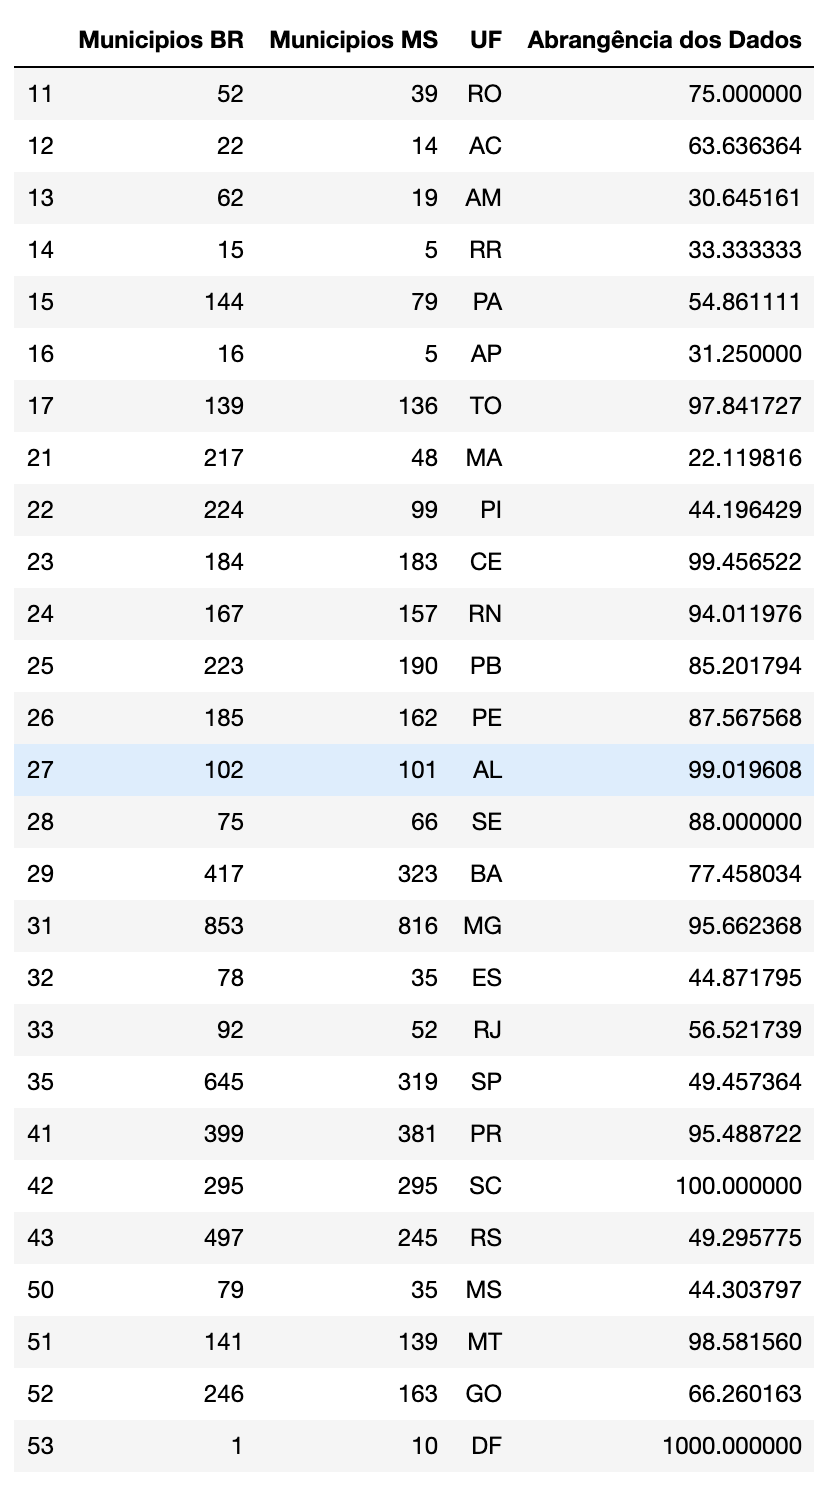

# Dependencies

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import json
import locale
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt

import pymysql
from pandas.io import sql as psql
from sqlalchemy import create_engine

import matplotlib.pyplot as plt
locale.setlocale(locale.LC_ALL, 'pt_BR.UTF-8')

'pt_BR.UTF-8'

# Micro Dataset Filter params

In [2]:
#ACRE = 12
#DISTRITOFEDERAL = 53
#ALAGOAS = 27
uf = 'ALAGOAS'
uf_co = 27
catmat = '0272832'
ds_produto = 'QUETIAPINA'

# Load ARIMA Data from CSV

In [3]:
csv_arimaset_df = pd.read_csv('sourceset/predicao2013a2018.csv')
csv_arimaset_df.groupby(['UF']).mean().head()

EXERCICIO  TRIMESTRE
UF                                       
ACRE             201552.085106   2.489362
ALAGOAS          201552.085106   2.489362
AMAPÁ            201550.915852   2.587751
CEARÁ            201552.623563   2.448017
DISTRITOFEDERAL  201545.478261   2.646071

In [4]:
csv_arimaset_df.groupby(['MEDICAMENTO']).mean().head()

EXERCICIO  TRIMESTRE
MEDICAMENTO                                                                 
ABATACEPTE 125 MG/ML SOL INJ (SER PREENC) 1 ML ...  201550.338308   2.715980
ABATACEPTE 250 MG PÓ P/ SUSP INJ (FR-AMP) GRUPO...  201551.776876   2.495660
ADALIMUMABE 40 MG/ML SOL INJ (SER PREENC) GRUPO...  201551.776876   2.491676
ADEFOVIR 10 MG COMP GRUPO 1.A                       201551.776876   2.501005
ALFADORNASE 2.5MG AMP GRUPO 1.A                     201550.338308   2.694761

In [5]:
# list(csv_arimaset_df.groupby(['MEDICAMENTO']))

In [6]:
csv_arimaset_df = csv_arimaset_df[csv_arimaset_df['UF'] == uf]
csv_arimaset_df = csv_arimaset_df[csv_arimaset_df['MEDICAMENTO'].str.contains(ds_produto)]

csv_arimaset_df.head()

UF  EXERCICIO  TRIMESTRE                       MEDICAMENTO  \
27706  ALAGOAS   201301.0          1  QUETIAPINA 100 MG COMP GRUPO 1.A   
27707  ALAGOAS   201301.0          1  QUETIAPINA 200 MG COMP GRUPO 1.A   
27708  ALAGOAS   201301.0          1   QUETIAPINA 25 MG COMP GRUPO 1.A   
27709  ALAGOAS   201301.0          1  QUETIAPINA 300 MG COMP GRUPO 1.A   
27804  ALAGOAS   201301.0          2  QUETIAPINA 100 MG COMP GRUPO 1.A   

                    QTD  
27706   63932.759822373  
27707  116474.446420721  
27708  71167.4402109574  
27709  1306.63043142293  
27804  62842.1497295626

In [7]:
csv_arimaset_df.groupby(['TRIMESTRE']).mean().head()

EXERCICIO
TRIMESTRE               
1          201570.320000
2          201533.500000
3          201545.434783
4          201556.500000

# Load Data from DB

In [8]:
db_connection_str = 'mysql+pymysql://root:@localhost:3306/datasource_development'
db_connection = create_engine(db_connection_str)

query = "SELECT DATE_FORMAT(NU_COMPETENCIA_DISPENSACAO, '%%Y%%m') AS DT, DATE_FORMAT(NU_COMPETENCIA_DISPENSACAO, '%%m') AS MES, SUM(MONTANTE_DISPENSADA) AS QTD FROM datasource_development.bnafar_dispensations WHERE NU_CATMAT LIKE '%%{}%%' AND COORD LIKE 'CEAF' AND SUBSTRING(CO_MUNICIPIO_IBGE_EST, 1, 2) LIKE '{}' GROUP BY DT, MES ORDER BY DT;".format(catmat,uf_co)
print(query)

SELECT DATE_FORMAT(NU_COMPETENCIA_DISPENSACAO, '%%Y%%m') AS DT, DATE_FORMAT(NU_COMPETENCIA_DISPENSACAO, '%%m') AS MES, SUM(MONTANTE_DISPENSADA) AS QTD FROM datasource_development.bnafar_dispensations WHERE NU_CATMAT LIKE '%%0272832%%' AND COORD LIKE 'CEAF' AND SUBSTRING(CO_MUNICIPIO_IBGE_EST, 1, 2) LIKE '27' GROUP BY DT, MES ORDER BY DT;


In [9]:
started_at = datetime.now()
db_microset_df = pd.read_sql(query, con=db_connection)
db_microset_df['MES'] = db_microset_df['MES'].astype(int)
ended_at = datetime.now()
spent = ended_at - started_at
print('Spent Time: ', spent)#.strftime('%Y-%m-%d %H:%M:%S')
print('DB DF Head')
db_microset_df.QTD = db_microset_df.QTD.astype(int)
db_microset_df.head()

Spent Time:  0:00:06.490703
DB DF Head


DT  MES   QTD
0  201112   12   390
1  201201    1  1500
2  201202    2  1875
3  201203    3  2785
4  201204    4  3525

In [10]:
print('CSV DF Head')
small_csv_arimaset_df = csv_arimaset_df.drop(columns=['TRIMESTRE', 'MEDICAMENTO', 'UF'])
small_csv_arimaset_df = small_csv_arimaset_df.rename(columns={"EXERCICIO": "DT"})
small_csv_arimaset_df.DT = small_csv_arimaset_df.DT.astype(int)
small_csv_arimaset_df['MES'] = small_csv_arimaset_df.DT.astype(str).str[4:6]
small_csv_arimaset_df.QTD = small_csv_arimaset_df.QTD.str.split(".", n = 1, expand = True) 

final_small_csv_arimaset_df = pd.DataFrame({'DT':small_csv_arimaset_df.DT,'MES':small_csv_arimaset_df.MES,'QTD':small_csv_arimaset_df.QTD})
final_small_csv_arimaset_df.head()

CSV DF Head


DT MES     QTD
27706  201301  01   63932
27707  201301  01  116474
27708  201301  01   71167
27709  201301  01    1306
27804  201301  01   62842

# Output dataset
arimaset-quetiapina-alagoas.csv & microset-quetiapina-alagoas.csv

In [11]:
final_small_csv_arimaset_df.to_csv('datasets/arimaset-quetiapina-alagoas.csv', index=False, encoding='utf8')
db_microset_df.to_csv('datasets/microset-quetiapina-alagoas.csv', index=False, encoding='utf8')